In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import glob
import os
from google.colab.patches import cv2_imshow
from skimage.exposure import match_histograms
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as k
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

In [ ]:
!unzip /content/drive/MyDrive/CV/Dataset.zip -d Dataset
!unzip /content/drive/MyDrive/CV/Patterns.zip -d Patterns

Archive:  /content/drive/MyDrive/CV/Dataset.zip
replace Dataset/1644359422.816138.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def perspective(img, img_pattern):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_img_pattern = cv2.cvtColor(img_pattern, cv2.COLOR_BGR2GRAY)
  detect = cv2.ORB_create()
  key_pt1,desc1 = detect.detectAndCompute(gray_img,None)
  key_pt2,desc2 = detect.detectAndCompute(gray_img_pattern,None)
  if type(desc1)!=type(None) and type(desc2)!=type(None) and desc1.shape[1] == desc2.shape[1]:
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    no_of_matches = brute_force.match(desc1,desc2)
    
    matches = sorted(no_of_matches,key=lambda x:x.distance)  
      
    list_kp1 = np.float32([[int(key_pt1[mat.queryIdx].pt[0]), int(key_pt1[mat.queryIdx].pt[1])] for mat in matches]) 
    list_kp2 = np.float32([[int(key_pt2[mat.trainIdx].pt[0]), int(key_pt2[mat.trainIdx].pt[1])] for mat in matches])

    if len(list_kp1) >= 4:
      h, mask = cv2.findHomography(list_kp1, list_kp2, cv2.RANSAC, 5.0)
      perspective_img = cv2.warpPerspective(img, h, img.shape[:2])
      return perspective_img, h,1
    else:
      print("FAILED")
      return img, 0,0
  else:
      print("FAILED")
      return img, 0,0

In [ ]:
def get_mask(im, json_file):
    mask = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
    for shape in json_file['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    return mask

In [ ]:
files = glob.glob("/content/Dataset/*")
idx=0
for idx in range(len(files)) :
  file = files[idx]
  if(file.endswith('.json')):
    continue
  f = open(file[:-3]+"json", encoding="utf8")
  json_file = json.load(f)
  f.close()
  img1 = cv2.imread(file)
  mask_img = get_mask(img1,json_file)
  mask_img = mask_img[75:-75,75:-75] 
  img1 = img1[75:-75,75:-75] 
  
  img2 = cv2.imread('/content/Patterns/' + json_file['pattern'])      
  img2 = cv2.resize(img2, img1.shape[:2])
  matched_img, t,r = perspective(img2, img1)
  if(not r):
    continue
  url = f"/content/drive/MyDrive/CV/Lastxxxx/img{idx}"
  cv2.imwrite(url+file[-4:], img1)
  cv2.imwrite(url+"_mask"+file[-4:], mask_img)
  cv2.imwrite(url+json_file['pattern'][-4:], matched_img)
  

#Siamese Model V1

In [4]:
def create_model():
    inputs = layers.Input((16, 16, 1))
    x =  layers.Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    pooledOutput = layers.GlobalAveragePooling2D()(x)
    pooledOutput = layers.Dense(1024)(pooledOutput)
    outputs = layers.Dense(128)(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model

In [5]:
feature_extractor = create_model()
imgA = layers.Input(shape=(16, 16, 1))
imgB = layers.Input(shape=(16, 16, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

In [6]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = layers.Lambda(euclidean_distance)([featA, featB])
outputs = layers.Dense(1, activation="sigmoid")(distance)
model =  keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [7]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
def sliding_window(image, stepSize, windowSize):
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [9]:
def crop_image(image,points):
    x,y,xw,yh = points
    return image[y:yh, x:xw]

In [ ]:
files = glob.glob("/content/drive/MyDrive/CV/Last/*")
pair_images = []
pair_labels = []
(winW, winH) = (16,16)
for idx in range(len(files)) :
  file = files[idx]
  if(file.endswith('.tif') or file.__contains__('mask')):
    continue
  img = cv2.imread(file,0)
  pattern_img = cv2.imread(file[:-4]+".tif",0)
  mask_img = cv2.imread(file[:-4]+"_mask"+file[-4:],0)

  for (x, y, window) in sliding_window(img, stepSize=16, windowSize=(winW, winH)):
      if (window.shape[0] != winH or window.shape[1] != winW):
        continue
      box = [x,y,x+winW,y+winH]
      box_img = crop_image(img,box)
      box_pattern_img = crop_image(pattern_img,box)
      box_mask_img = crop_image(mask_img,box)
      pair_images.append((box_img,box_pattern_img))
      count = np.count_nonzero(box_mask_img)
      if(count>100):
        pair_labels.append(1)
      else:
        pair_labels.append(0)



In [19]:
from keras.applications.resnet import preprocess_input

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, dim=(16, 16), n_channels=1, shuffle=True):
        'Initialization'
        self.files = data
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Initialization
        pair_images = np.empty((self.batch_size, *self.dim, self.n_channels))
        pair_labels = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ind in enumerate(indexes):
              file = files[ind]
              if(file.endswith('.tif') or file.__contains__('mask')):
                continue
              img = cv2.imread(file,0)
              pattern_img = cv2.imread(file[:-4]+".tif",0)
              mask_img = cv2.imread(file[:-4]+"_mask"+file[-4:],0)
              (winW, winH) = self.dim
              for (x, y, window) in sliding_window(img, stepSize=16, windowSize=(winW, winH)):
                  if (window.shape[0] != winH or window.shape[1] != winW):
                    continue
                  box = [x,y,x+winW,y+winH]
                  box_img = crop_image(img,box)
                  box_pattern_img = crop_image(pattern_img,box)
                  box_mask_img = crop_image(mask_img,box)
                  pair_images[i]=(box_img,box_pattern_img)
                  count = np.count_nonzero(box_mask_img)
                  if(count>100):
                    pair_labels[i]=1
                  else:
                    pair_labels[i]=0
        return 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


In [ ]:
files = glob.glob("/content/drive/MyDrive/CV/Last/*")
train_generator = DataGenerator(files)
valid_generator = DataGenerator(files, shuffle=False)
X, y = train_generator.__getitem__(1)
print(X.shape)
print(y.shape)

In [ ]:
history = model.fit(train_generator,validation_data=valid_generator,bacepochs=50,batch_size=4)

#Siamese(U-NET) Model V2

In [21]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((256,256), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
embedding_network = get_model((256,256), 1)
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input_1 = layers.Input((256, 256, 3))
input_2 = layers.Input((256, 256, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
merge_layer = layers.Concatenate()([tower_1, tower_2])
# subtracted = keras.layers.Subtract()([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [24]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [25]:
siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 256, 256, 1)  2058401     ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

In [26]:
files = glob.glob("/content/drive/MyDrive/CV/Last/*")
x_train = []
y_train = []
(winW, winH) = (256,256)
for idx in range(len(files)) :
  file = files[idx]
  if(file.endswith('.tif') or file.__contains__('mask')):
    continue
  img =cv2.resize(cv2.imread(file),(winW, winH))
  pattern_img = cv2.resize(cv2.imread(file[:-4]+".tif"),(winW, winH))
  mask_img = cv2.resize(cv2.imread(file[:-4]+"_mask"+file[-4:],0),(winW, winH))
  x_train.append((img,pattern_img))
  y_train.append(mask_img)

In [29]:
x_train,y_train  = np.array(x_train),np.array(y_train).astype("float32")
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)


In [115]:
print(x_train[1].shape)

(256, 256, 3)


In [30]:
# Train the model, doing validation at the end of each epoch.
history = siamese.fit([x_train[:, 0], x_train[:, 1]],y_train,batch_size=4,epochs=5, validation_data=([x_test[:, 0], x_test[:, 1]], y_test))


Epoch 1/5
61/61 [==============================] - 350s 6s/step - loss: 0.2457 - accuracy: 0.9986 - val_loss: 0.2414 - val_accuracy: 0.9983
Epoch 2/5
61/61 [==============================] - 318s 5s/step - loss: 0.2392 - accuracy: 0.9986 - val_loss: 0.2393 - val_accuracy: 0.9983
Epoch 3/5
61/61 [==============================] - 318s 5s/step - loss: 0.2333 - accuracy: 0.9986 - val_loss: 0.2373 - val_accuracy: 0.9983
Epoch 4/5
61/61 [==============================] - 319s 5s/step - loss: 0.2282 - accuracy: 0.9986 - val_loss: 0.2356 - val_accuracy: 0.9983
Epoch 5/5
61/61 [==============================] - 325s 5s/step - loss: 0.2242 - accuracy: 0.9986 - val_loss: 0.2346 - val_accuracy: 0.9983


In [108]:
history = siamese.fit([x_train[:, 0], x_train[:, 1]],y_train,batch_size=4,epochs=5, validation_data=([x_test[:, 0], x_test[:, 1]], y_test))


Epoch 1/5
49/49 [==============================] - 176s 3s/step - loss: 0.2450 - accuracy: 0.9987 - val_loss: 0.2173 - val_accuracy: 0.9986
Epoch 2/5
49/49 [==============================] - 163s 3s/step - loss: 0.2379 - accuracy: 0.9987 - val_loss: 0.2133 - val_accuracy: 0.9986
Epoch 3/5
49/49 [==============================] - 164s 3s/step - loss: 0.2317 - accuracy: 0.9987 - val_loss: 0.2112 - val_accuracy: 0.9986
Epoch 4/5
49/49 [==============================] - 160s 3s/step - loss: 0.2262 - accuracy: 0.9987 - val_loss: 0.2102 - val_accuracy: 0.9986
Epoch 5/5
49/49 [==============================] - 164s 3s/step - loss: 0.2216 - accuracy: 0.9987 - val_loss: 0.2098 - val_accuracy: 0.9986


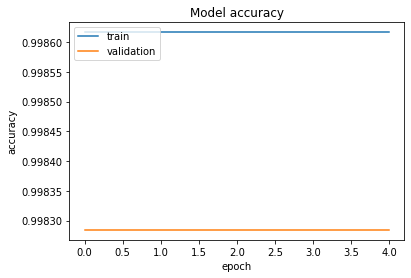

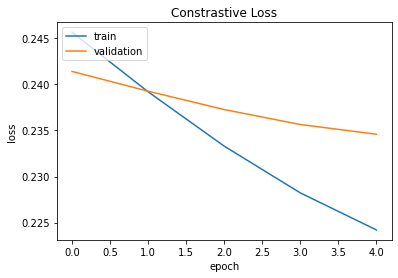

In [32]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

U-Net model


In [ ]:
files = glob.glob("/content/drive/MyDrive/CV/Last/*")
x_test= []
(winW, winH) = (256,256)
for idx in range(len(files)) :
  file = files[idx]
  if(file.endswith('.tif') or file.__contains__('mask')):
    continue
  img =cv2.resize(cv2.imread(file),(winW, winH))
  pattern_img = cv2.resize(cv2.imread(file[:-4]+".tif"),(winW, winH))
  prediction = siamese.predict([img, pattern_img])[0][0]

In [46]:
model = get_model((256,256), 1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
history = model.fit(x_train[:, 0],y_train,batch_size=4,epochs=5, validation_data=(x_test[:, 0], y_test))


In [ ]:
history = model.fit(x_train[:, 0],y_train,batch_size=4,epochs=5, validation_data=(x_test[:, 0], y_test))


#Testing Part

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [62]:
results = siamese.evaluate([x_test[:, 0], x_test[:, 1]], y_test)
print("test loss, test acc:", results)

2/2 [==============================] - 20s 10s/step - loss: 0.2303 - accuracy: 0.9984
test loss, test acc: [0.23026850819587708, 0.9983985424041748]
